In [2]:
import os
import csv
import shutil
import glob
from nltk.corpus import stopwords
from nltk import word_tokenize
from os import path, listdir
import collections
from collections import namedtuple
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

folder = "NEWS_TXT_v4/"
perDayFolders = "v4/"
prefix = path.expanduser("~/gdrive/research/nlp/data/")
vocab_folder = "google_vocab/"
stop_words = stopwords.words("english")

# Four Tasks

-  Task 1: Files Preprocessing. Each press release should be preprocessed and stored on disk. These preprocessed files are the ones used to create the doc2vec model
-  Task 2: doc2vec Model Generation. Progressively create doc2vec models, from year 0 to year "t", where t=1994,...,2015. These doc2vec models are stored within each year directory.
-  Task 3: Distance Matrix Computation. Given a time period (a day, a month, etc.) load all the files belonging to that period (the corpus) and compute the distance matrix. This matric could be stored on disk.
-  Task 4: Clustering. Use the distance matrix to carry out specific studies of press releases over time.

In addition, there is also a Task 0, which is the restructuring and organization of the different folders. This is the first task carried out below.

## Task 0: Restructuring Directories and Moving Files

Move each file in the corresponding year folder and, within the year, the corresponding day and month. For example, a file issued on January 21st, 2015 will be stored in the folder:

-  2015/01_21/fullname.txt

We also create a global mapping for all the files in the dataset. The mapping gives a unique identifier for each file in the dataset and it is saved in the file `mapping.txt`.


In [ ]:
fmap = open("mapping.txt", "w")

fullpath = path.join(prefix,folder)
for f in listdir(fullpath):
    print("name is = ", f)
    
    fName = f[:-4]
    print("Now fName is = ", fName)
    fAux = fName.split("_")
    print(fAux)
    year = fAux[1]
    dirLevel1 = path.join(prefix,perDayFolders) + year
    if not os.path.exists(dirLevel1):
        os.makedirs(dirLevel1)
    dirLevel2 = dirLevel1 + "/" + fAux[2] + "_" + fAux[3]
    fmap.write("{0}\t {1}\t {2}\t {3}\t {4}\n".format(f,fAux[0],fAux[1],fAux[2],fAux[3]))
    if not os.path.exists(dirLevel2):
        os.makedirs(dirLevel2)
    origin = fullpath + f
    dest   = dirLevel2 + "/" + f
    shutil.copy2(origin, dest)
    print("copying from ", origin, " to ", dest)
    
fmap.close()
  

## Task 1: Files Preprocessing

We now get into each directory of the current year, and add each file within that directory to the corpus. In addition, we write a _preprocessed_ version of the file (suffix `.pre`).

Let us first import the mapping filename $\rightarrow$ tag. Here we are reading the whole list, i.e., the entire dataset. We define two structures to query the filename and the absolute id value:
-  `file2tag`: Given a file name, it returns the corresponding unique identifier
-  `tag2file`: Given a unique identifier, i.e., a tag, it returns the full file name (cik_year_month_day.txt)

We also create a dataframe, `dfMap`, which contains all the information associated to a specific file, i.e., full name, cik, year, month, day, tag.

For the preprocessing phase, we use the following criteria:
- exclude all words with length $\leq$ 2
- exclude all words that are not alphabetic (`isalpha()` from nltk)
- exclude stopwords
- exclude all words which are not in the google news dictionary (cut to the 500k most frequent words)

In [282]:
fullpath = path.join(prefix,vocab_folder)
name_vocab = fullpath + "embed500.vocab"
with open(name_vocab) as f:
    vocab_list = map(str.strip,f.readlines())
vocab_dict = {w:k for k,w in enumerate(vocab_list)}

In [ ]:
nRows = sum(1 for line in open('mapping.txt'))
dfMap = pd.DataFrame(index=np.arange(0, nRows), columns=('name', 'cik', 'year', 'month','day','tag') )

with open("mapping.txt", "r") as f:
    row = 0
    for line in f:
        print(line)
        line=line.rstrip() # remove \n from each row
        dfMap.loc[row] = line.split(",")
        row += 1
dfMap["year"] = dfMap["year"].astype("int")   
dfMap["month"] = dfMap["month"].astype("int")   
dfMap["day"] = dfMap["day"].astype("int")   
dfMap["tag"] = dfMap["tag"].astype("int")   
#print(dfMap.dtypes)
file2tag = {f:t for f,t in zip(dfMap["name"],dfMap["tag"])}
tag2file = {t:f for t,f in zip(dfMap["tag"],dfMap["name"])}

#print(file2tag["11544_1996_12_13.txt"])
#print(tag2file["10"])

In [3]:
df = pd.read_csv("mapping.txt")
print(df)

      723371_1995_08_11.txt   723371  1995   8  11    0
0     352510_1995_09_22.txt   352510  1995   9  22    1
1     723926_1996_06_04.txt   723926  1996   6   4    2
2     873364_1996_06_14.txt   873364  1996   6  14    3
3      32017_1996_06_20.txt    32017  1996   6  20    4
4      69598_1996_06_24.txt    69598  1996   6  24    5
5     893670_1996_07_12.txt   893670  1996   7  12    6
6      42872_1996_08_09.txt    42872  1996   8   9    7
7     770975_1996_10_18.txt   770975  1996  10  18    8
8     943358_1996_11_26.txt   943358  1996  11  26    9
9      11544_1996_12_13.txt    11544  1996  12  13   10
10    899689_1997_03_26.txt   899689  1997   3  26   11
11   1000301_1997_05_13.txt  1000301  1997   5  13   12
12     43512_1997_05_22.txt    43512  1997   5  22   13
13    933730_1997_05_23.txt   933730  1997   5  23   14
14    351127_1997_06_19.txt   351127  1997   6  19   15
15    106640_1997_07_17.txt   106640  1997   7  17   16
16    922519_1997_07_17.txt   922519  1997   7  

In [3]:
year0 = "2014"
yearT = "2015"


In [ ]:
yearSet = list(range(int(year0), int(yearT)+1))

for year in yearSet:
    
    dirFull = path.join(prefix,perDayFolders) + str(year)
    print(dirFull)

    for ff in listdir(dirFull):
        print("Entering folder ", ff)
        filteredList = path.join(dirFull,ff) + "/*.txt"
        for f in glob.glob(filteredList):

            fullname = path.join(dirFull,ff,f)
            if os.path.isfile(fullname+".pre"):
                continue

            fTxt = open(fullname)
            doc = fTxt.read()
            words = [w.lower() for w in word_tokenize(doc) if w not in stop_words]
            words = [w for w in words if len(w) > 2 and w.isalpha() and w in vocab_dict]

            preprocName = fullname+".pre"
            fPre = open(preprocName, "w")
            writerDoc = csv.writer(fPre)
            writerDoc.writerows([words])
            fPre.close()


In [295]:
"bae" in vocab_dict

True

## Task 2: doc2vec model creation

We now need to read all the files belonging to a given year (later, up to that year) and build a doc2vec model to be used with the documents of that year. The doc2vect model is stored within the folder of that year and a suffix `.year` is added to each model.

In [6]:
from gensim.models import doc2vec
import logging
logging.basicConfig(
        format='%(asctime)s : %(threadName)s : %(levelname)s : %(message)s',
        level=logging.INFO
)


[NOT NEEDED ANYMORE] First, let us define a function used to determine whether a certain document matches the criteria used to define which documents will be employed to build the distance matrix (typically, year-month-day or any subset of that)

In [287]:
def isSelected(name, year, month, day):
    name= name[:-4]
    cik, yy, mm, dd = name.split("_")
    if yy == year:
        return True
    else:
        return False

Now, we import all the preprocessed files relative to the period considered in the construction of the doc2vec model.

**Rem.:** To build the doc2vec model, we use all the files in the period year0 to yearT. However, the distance matrix computation only includes the document in a prespecified period, e.g., a year, or a day. For this reason, we define here a new dictionary, called `corpus2tag`, which is used to identify which documents of the current corpus belong to a given time window. There are the only documents for which we want to compute the distance matrix.

Two tags:
-  the fist is the id number within the corpus
-  the second is the absolute id number, i.e., within the entire dataset

Each document embedding can be accessed via any of the two tags.


In [87]:
yearT = "2015"
year0 = "2014"
yearSet = list(range(int(year0), int(yearT)+1))

docs = []
tagsAbs = []
corpusID = []
absID = []
analyzedDocument = namedtuple('AnalyzedDocument','words tags')
i = 0
for year in yearSet:
    print("Considering year ", year)
    dirFull = path.join(prefix,perDayFolders) + str(year)
 
    for ff in listdir(dirFull):
        filteredList = path.join(dirFull,ff) + "/*.txt.pre"
        for f in glob.glob(filteredList):
            name = f.split("/")[-1]
            name = name[:-4]
            #selected = 0
            #print(name, file2tag[name])
            #if isSelected(name, yearT, [], []):
            #    corpusID.append(i)
            #    absID.append(file2tag[name])
            #    selected = 1
                
            fullname = path.join(dirFull, ff, f)
            fToken = open(fullname, "r")
            readerDoc = csv.reader(fToken)
            doc = next(readerDoc)
            fToken.close()
            #tags = [i,str(file2tag[name])]
            tags = [str(file2tag[name])] 
            #absID.append(file2tag[name])
            docs.append(analyzedDocument(doc,tags))

            i = i + 1
    print("Corpus with {0:5d} documents.".format(len(docs)))

#corpus2tag = {id:t for id,t in zip(corpusID,absID)}
#print("List of documents included in the considered time window::")
#print(corpus2tag)
#verify
#print(docs[64])
#print(tag2file[corpus2tag[64]])

Considering year  2014
Corpus with    40 documents.
Considering year  2015
Corpus with    68 documents.


In [88]:
# creating doc2vec model for the current year
model = doc2vec.Doc2Vec(size=300, window=100, min_count=2, iter=200, workers=4, dm=1, negative=10)
model.build_vocab(docs)
model.train(docs, total_examples=model.corpus_count, epochs=model.iter)
model.init_sims(replace=True)

# save model on disk
nameModel = "doc2vec.model." + str(year)
fullname = path.join(dirFull,nameModel)
print("Saving model ", fullname)
model.save(fullname)
model.delete_temporary_training_data(keep_doctags_vectors=True, keep_inference=True)

# save mapping id-->tag on disk
#nameMap = "mapping.doc2vec." + str(year)
#fullname = path.join(dirFull,nameMap)
#print("Saving mapping ", fullname)
#f = open(fullname, "w")
#writer = csv.writer(f)
#for i in range(len(absID)):
#    writer.writerow([i,absID[i]])
#f.close()


2018-04-05 09:26:17,214 : MainThread : INFO : collecting all words and their counts
2018-04-05 09:26:17,215 : MainThread : INFO : PROGRESS: at example #0, processed 0 words (0/s), 0 word types, 0 tags
2018-04-05 09:26:17,247 : MainThread : INFO : collected 5053 word types and 68 unique tags from a corpus of 68 examples and 65032 words
2018-04-05 09:26:17,255 : MainThread : INFO : Loading a fresh vocabulary
2018-04-05 09:26:17,279 : MainThread : INFO : min_count=2 retains 3292 unique words (65% of original 5053, drops 1761)
2018-04-05 09:26:17,285 : MainThread : INFO : min_count=2 leaves 63271 word corpus (97% of original 65032, drops 1761)
2018-04-05 09:26:17,313 : MainThread : INFO : deleting the raw counts dictionary of 5053 items
2018-04-05 09:26:17,314 : MainThread : INFO : sample=0.001 downsamples 48 most-common words
2018-04-05 09:26:17,316 : MainThread : INFO : downsampling leaves estimated 51991 word corpus (82.2% of prior 63271)
2018-04-05 09:26:17,317 : MainThread : INFO : es

Saving model  /home/marco/gdrive/research/nlp/data/v4/2015/doc2vec.model.2015


In [89]:
print(len(model.docvecs))

68


## Task 3: Using doc2vec model

Here, we upload a doc2vec model for a specific year and use it to build a distance matrix. In addition, to separate model creation from model use, we need to find out which documents belong to the corpus.

**Rem.:** There are two ways of using a doc2vec model: i. Getting the embedding of a document stored within the doc2vec model. Obviously, this requires that the document was actually used in the doc2vec creation phase. We also need to know the tag associated to that document. We can then refer to the embedding using the tag; (ii) Inferring an embedding vector and treating the document as a new, unseen one. In this case, whether the document was used or not durign the doc2vec model creation phase does not matter, since the model will provide an embedding for a document, treating it as unseen. 

While approach i. is deterministic (it always returns the same embedding for a document), approach ii. is stochastic (the embedding vector is different every time we ask to compute the inferred vector.

In [90]:
# define the year and read corresponding doc2vec model
year = "2015"
dirFull = path.join(prefix,perDayFolders) + year
fullname = dirFull + "/doc2vec.model." + year
print("Loading model ", fullname)
modelDoc2Vec = doc2vec.Doc2Vec.load(fullname)
print("The model contains {0} vectors.".format(len(modelDoc2Vec.docvecs)))


2018-04-05 09:34:02,308 : MainThread : INFO : loading Doc2Vec object from /home/marco/gdrive/research/nlp/data/v4/2015/doc2vec.model.2015
2018-04-05 09:34:02,393 : MainThread : INFO : loading wv recursively from /home/marco/gdrive/research/nlp/data/v4/2015/doc2vec.model.2015.wv.* with mmap=None
2018-04-05 09:34:02,396 : MainThread : INFO : setting ignored attribute syn0norm to None
2018-04-05 09:34:02,398 : MainThread : INFO : loading docvecs recursively from /home/marco/gdrive/research/nlp/data/v4/2015/doc2vec.model.2015.docvecs.* with mmap=None
2018-04-05 09:34:02,401 : MainThread : INFO : setting ignored attribute cum_table to None
2018-04-05 09:34:02,402 : MainThread : INFO : loaded /home/marco/gdrive/research/nlp/data/v4/2015/doc2vec.model.2015


Loading model  /home/marco/gdrive/research/nlp/data/v4/2015/doc2vec.model.2015
The model contains 68 vectors.


In [91]:
# just a little test
modelDoc2Vec.most_similar("good")

2018-04-05 09:34:06,008 : MainThread : INFO : precomputing L2-norms of word weight vectors


[('morning', 0.8003968000411987),
 ('session', 0.5685198307037354),
 ('comes', 0.5152820944786072),
 ('distributing', 0.48078060150146484),
 ('essential', 0.44736558198928833),
 ('happen', 0.44607722759246826),
 ('instructions', 0.4353036880493164),
 ('question', 0.3995822072029114),
 ('pharmaceuticals', 0.3972008526325226),
 ('pinnacle', 0.3752984404563904)]

In [ ]:
modelDoc2Vec.wv.vocab # to get the vocabulary

## Task 3: Distance Matrix Computation

We can use two approaches to similarity computation:
- Using the actual doc2vec embedding vector
- Using an inferred vector


### Using the actual doc2vec embedding vector

Each document in the corpus is now associated to a vector, contained in the doc2vec model. We can simply get the vector by using `modelDoc2Vec[doc]` to get the embedding of the document. However, the problem here is that, if in the model creation phase we eliminated, e.g., all the words that appear only once (`min_count=2`), then it might happen that we cannot get back the actual vector associated to `doc` (an error message notifies that a given word is not in the vocabulary.) We thus need to screen the document and eliminate all the words that are not in the vocabulary. 

Alternatively, and much simpler, we can get the tag of each document in the current corpus, and directly obtain the embedding of that document using `modelDoc2Vec.docvecs[tag]`. Since here we are accessing a pre-computed embedding, without using the actual document, we do not have the problem described above. Note that, in this case, we do not even need to load the document in memory, since with the tag it will suffice.

Let us first get a list of documents tag to be used to compute the distance matrix. Which documents should be included here depends on the strategy used. For now, assume we want to use all the documents of a given year. 

__Note:__ In this case, we do not even need to load the corpus. We just need to create a list of tags corresponding to the documents we want to use in the distance matrix computation.

In [92]:
# get absolute tag for all documents belonging to a given year
year = "2015"
tagList = []
nRows = len(dfMap)
for row in range(nRows):
    #print(dfMap.iloc[row])
    if dfMap.iloc[row]["year"] == int(year):
        #print("file ", dfMap.iloc[row]["name"], " selected")
        tagList.append(dfMap.iloc[row]["tag"])
print(tagList)

[972, 973, 974, 975, 976, 977, 978, 979, 980, 981, 982, 983, 984, 985, 986, 987, 988, 989, 990, 991, 992, 993, 994, 995, 996, 997, 998, 999]


In [ ]:
print(sorted(corpus2tag.values()))
print(sorted(corpus2tag.keys()))

Now, compute the pairwise distances among all the documents in the `tagList`. The distance matrix is stored in long format in a disk file. Note that we store only the upper diagonal matrix (since distances are symmetric here). The format is:
- first row: number of documents in this corpus, e.g., $n$. Thus, the number of pairwise distances in the file is $n(n+1)/2$.)
- second row: list of tagged documents included in this distance matrix ($n$ elements)
- from row 3 to $n(n+1)/2 + 3$, the following table:

|from|to|distance|
|----|----|-----|
|0|0|0|
|0|1|0.23|
|..|..|..|


In [128]:
nDocs = len(tagList)
nameMatrix = "doc2vecDistMatrix.txt." + str(year)
fullname = path.join(dirFull,nameMatrix)

f = open(fullname, "w")
writer = csv.writer(f)
writer.writerow([nDocs])
writer.writerow(tagList)
vals = [ [0.0 for i in range(nDocs)] for j in range(nDocs)]
    
for i in range(nDocs):
    tag_i = tagList[i]
        
    for j in range(i,nDocs):
        tag_j = tagList[j]
        val = round(1.0-modelDoc2Vec.docvecs.similarity(str(tag_i),str(tag_j)), 4)
        writer.writerow([tag_i, tag_j, val])

f.close()
print("Distance Matrix saved :: ", fullname)  

Distance Matrix saved ::  /home/marco/gdrive/research/nlp/data/v4/2015/doc2vecDistMatrix.txt.2015


### Using an inferred vector

[__Note:__ To use this part, we need to upload the corpus itself. It is not enough to have the tags associated to the documents of the corpus]. With _gensim_, it is possible to infer a vector associated to an (unseen) document. In this case, whether or not all the words of a document are in the vocabulary no longer matters. One could then create an inferred vector for each document in the corpus and find the closest document in the corpus w.r.t. the inferred vector. If the doc2vec model works, the closest document should always be itself. To test the quality of the doc2vec model used, we can then count how many time the closest document to each inferred vector is actually the original document itself.

Let us run a test to determine whether the doc2vec model is accurate. We compute the inferred vector for each document in the corpus. Next, we find the most similar document to each inferred vector. If the doc2vec model works, each document should return **itself** as most similar. Finally, we count how many times this happens (ideally, all the times).

At this stage, the accuracy of the answer seems to depend on the number of iterations used to generate the inferred vector.
 

In [95]:
corpus = []
listOfTags = []
print("Considering year ", year)
dirFull = path.join(prefix,perDayFolders) + str(year)

for ff in listdir(dirFull):
    filteredList = path.join(dirFull,ff) + "/*.txt.pre"
    for f in glob.glob(filteredList):
        name = f.split("/")[-1]
        name = name[:-4]
        listOfTags.append(file2tag[name])

        fullname = path.join(dirFull, ff, f)
        fToken = open(fullname, "r")
        readerDoc = csv.reader(fToken)
        doc = next(readerDoc)
        fToken.close()
        corpus.append(doc)

print("Corpus with {0:5d} documents.".format(len(corpus)))
print("List of Tags :: ", listOfTags)


Considering year  2015
Corpus with    28 documents.
List of Tags ::  [982, 981, 986, 985, 996, 972, 992, 987, 976, 998, 999, 980, 997, 991, 990, 984, 983, 995, 977, 989, 973, 988, 993, 979, 974, 975, 994, 978]


In [ ]:
ranks = []
for id in range(len(corpus)):

    inferred_vector = modelDoc2Vec.infer_vector(corpus[id], steps=200)
    tag = listOfTags[id] # this is int
    #print(inferred_vector)
    sims = modelDoc2Vec.docvecs.most_similar([inferred_vector], topn=len(modelDoc2Vec.docvecs))
    rank = [i for i,j in sims].index(str(tag))
    print("Vector {0:3d} : Rank = {1:3d} with score {2:5.3f}".format(id,rank,sims[rank][1]))
    ranks.append(rank)
    
collections.Counter(ranks) 

## Task 4: Clustering

We now use the distance matrix saved on disk within each folder to carry out a specific type of analysis. For now, we use hierarchical clustering. The goal, though, is to see how clusters change over time and other type of analysis to study correlations among PR.

In [123]:
import scipy.spatial.distance as ssd
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster, cophenet


In [130]:
### read distance matrix
year = "2015"
nameMatrix = "doc2vecDistMatrix.txt." + str(year)
fullname = path.join(dirFull,nameMatrix)

f = open(fullname, "r")
reader = csv.reader(f)
nDocs = int(next(reader)[0])
auxList = next(reader)
tagList = [int(auxList[i]) for i in range(len(auxList))]

distMatrix = [ [0.0 for i in range(nDocs)] for j in range(nDocs)]
i = -1
j = 0
for row in reader:
    if j % nDocs == 0:
        i += 1
        j = i
    ix = int(row[0])
    jx = int(row[1])
    d = float(row[2])

    distMatrix[i][j] = d
    distMatrix[j][i] = d
    
    #print("distance from {0:5d} ({1:5d}) to {2:5d} ({3:5d}) is {4:7.4f}".format(ix,i, jx, j,d))
    j += 1

f.close()

[972, 973, 974, 975, 976, 977, 978, 979, 980, 981, 982, 983, 984, 985, 986, 987, 988, 989, 990, 991, 992, 993, 994, 995, 996, 997, 998, 999]


In [125]:
distArray = ssd.squareform(np.asmatrix(distMatrix), checks=False)
methods = ["ward", "median", "average", "single", "complete"]
bestVal = 0.0
bestMethod = " "
for mm in methods:
    Z = linkage(distArray, method=mm, optimal_ordering=True)
    c, cophDist = cophenet(Z, distArray)
    print("[ {0:10s}] Cophenetic = {1:5.2f}".format(mm,c))
    if c > bestVal:
        bestVal = c
        bestMethod = mm
        
Z = linkage(distArray, method=bestMethod, optimal_ordering=True)


[ ward      ] Cophenetic =  0.76
[ median    ] Cophenetic =  0.82
[ average   ] Cophenetic =  0.86
[ single    ] Cophenetic =  0.84
[ complete  ] Cophenetic =  0.70


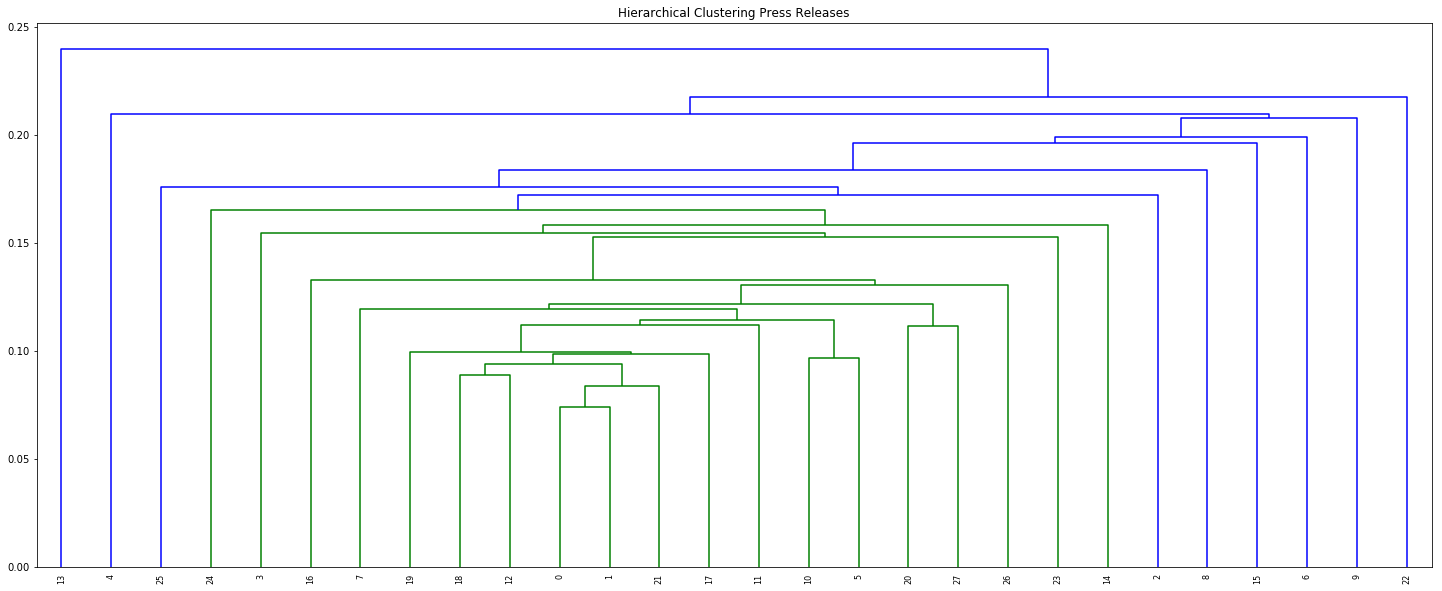

In [126]:
plt.figure(figsize=(25,10))
plt.title("Hierarchical Clustering Press Releases")
pp= dendrogram(
    Z,
    leaf_rotation=90,
    leaf_font_size=8.,
    show_leaf_counts=True,
    get_leaves=True,
#    truncate_mode="level",
#    p = 5
)
plt.show()



An alternative approach is based on the use of a k-mean clustering algorithm from the nltk library. The algorithm uses the vectors associated to each document (rather than the distance matrix.) Therefore, we need to get the embeddings of the documents in the current corpus.

In [127]:
import nltk
from nltk.cluster import KMeansClusterer

In [ ]:
# read doc2vec model
year = "2015"
dirFull = path.join(prefix,perDayFolders) + year
fullname = dirFull + "/doc2vec.model." + year
print("Loading model ", fullname)
modelDoc2Vec = doc2vec.Doc2Vec.load(fullname)
print("The model contains {0} vectors.".format(len(modelDoc2Vec.docvecs)))

nameMatrix = "doc2vecDistMatrix.txt." + str(year)
fullname = path.join(dirFull,nameMatrix)
# get taglist
f = open(fullname, "r")
reader = csv.reader(f)
nDocs = int(next(reader)[0])
auxList = next(reader)
tagList = [int(auxList[i]) for i in range(len(auxList))]
f.close()
print("Taglist is = ", tagList)

In [137]:
num_clusters = 4
vectors = [modelDoc2Vec.docvecs[str(i)] for i in tagList]
kclusterer = KMeansClusterer(num_clusters,
                            distance =nltk.cluster.util.cosine_distance,
                            repeats=500)
labels = kclusterer.cluster(vectors, assign_clusters=True)
print("Clusters Labels = ", labels)

Clusters Labels =  [3, 2, 0, 2, 0, 0, 1, 2, 3, 2, 3, 1, 2, 2, 0, 2, 2, 2, 3, 2, 1, 3, 3, 1, 3, 3, 2, 1]


## Statistical Analysis of Distance Matrix

In [15]:
def readDistMatrix(year):

    nameMatrix = "doc2vecDistMatrix.txt." + str(year)

    fullname = path.join(prefix,perDayFolders,year,nameMatrix)
    print("Fullname = ", fullname)
    f = open(fullname, "r")
    reader = csv.reader(f)
    nDocs = int(next(reader)[0])
    print("NDocs = ", nDocs)
    distMatrix = [ [0.0 for i in range(nDocs)] for j in range(nDocs)]
    auxList = next(reader)
    tagList = [int(auxList[i]) for i in range(len(auxList))]
    i = -1
    j =  0
    for row in reader:
        if j % nDocs == 0:
            i += 1
            j  = i
        ix = int(row[0])
        jx = int(row[1])
        d  = float(row[2])
        distMatrix[i][j] = d
        distMatrix[j][i] = d
        j += 1
    f.close()
    return distMatrix


In [32]:
import matplotlib.pyplot as plt
import seaborn as sns

Fullname =  /home/marco/gdrive/research/nlp/data/v4/2006/doc2vecDistMatrix.txt.2006
NDocs =  90
[0.         0.05454545 0.10909091 0.16363636 0.21818182 0.27272727
 0.32727273 0.38181818 0.43636364 0.49090909 0.54545455 0.6       ]


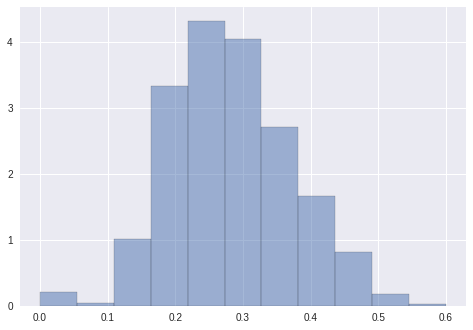

In [42]:
distMatrix = readDistMatrix("2006")
np.mean(distMatrix)

dd = [distMatrix[i][j] for i in range(nDocs) for j in range(nDocs)]

bins = np.linspace(0, 0.6, 12)
plt.hist(dd,bins=bins,alpha=0.5,edgecolor="black",normed=True)
plt.show()

Within the same company: Let us examine the distance within the same cik code.